### Import libraries

In [92]:
import pandas as pd
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import numpy as np
from catboost import Pool
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from catboost import CatBoostClassifier , cv, Pool
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC

### Exploratory Analysis

In [159]:
df = pd.read_csv('train.csv', index_col=0)

The first 5 rows of the dataset to understand its structure

In [94]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Stats for numerical variables

In [95]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Percentage of missing values in the columns

In [96]:
missing_values = df.isnull().mean().round(4) * 100
missing_values = missing_values[missing_values > 0]
missing_values

Age         19.87
Cabin       77.10
Embarked     0.22
dtype: float64

Distribution of the variable: 'Survived'

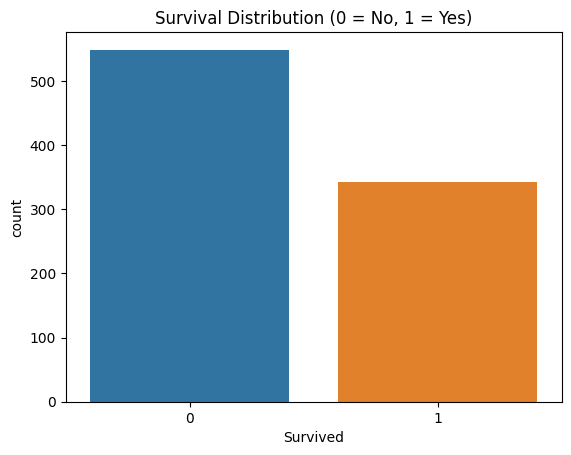

In [97]:
sns.countplot(x='Survived', data=df)
plt.title('Survival Distribution (0 = No, 1 = Yes)')
plt.show()

Distribution of varieble: 'Pclass'

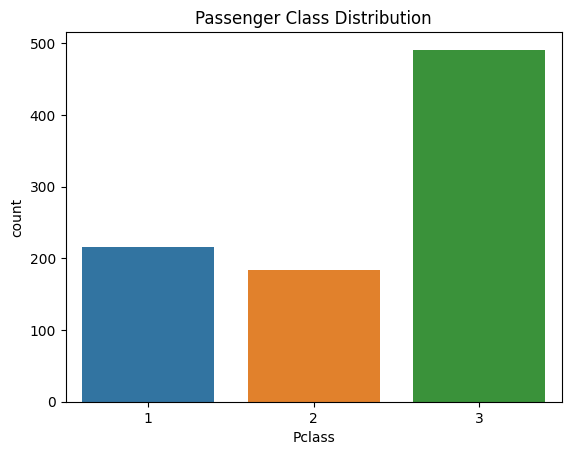

In [98]:
sns.countplot(x='Pclass', data=df)
plt.title('Passenger Class Distribution')
plt.show()

Age distribution

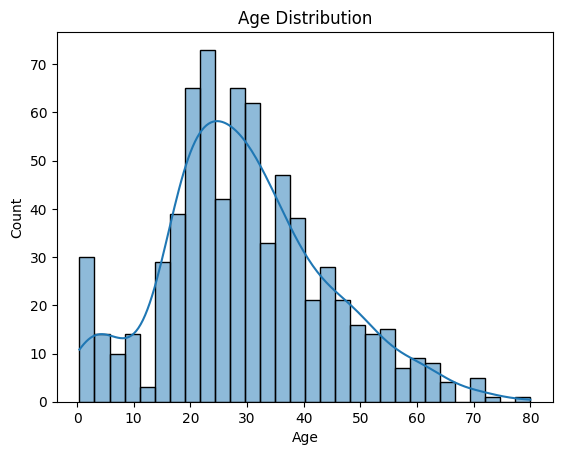

In [99]:
sns.histplot(df['Age'].dropna(), kde=True, bins=30)
plt.title('Age Distribution')
plt.show()

Survival comparison by gender

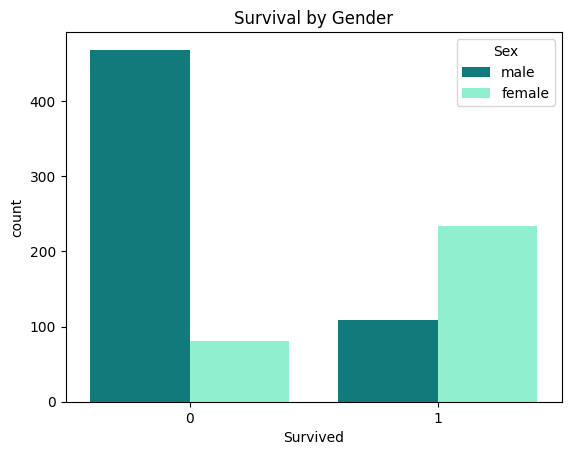

In [100]:
custom_palette = ['darkcyan', 'aquamarine']
sns.countplot(x='Survived', hue='Sex', data=df, palette=custom_palette)
plt.title('Survival by Gender')
plt.show()

Survival comparison by class

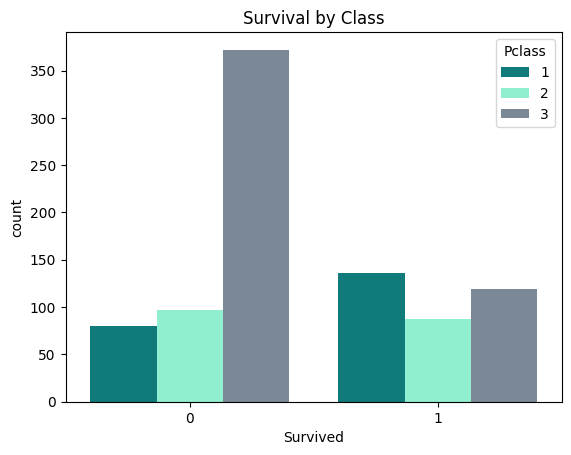

In [101]:
custom_palette = ['darkcyan', 'aquamarine', 'lightslategrey']
sns.countplot(x='Survived', hue='Pclass', data=df, palette=custom_palette)
plt.title('Survival by Class')
plt.show()

Analysis of the fare paid

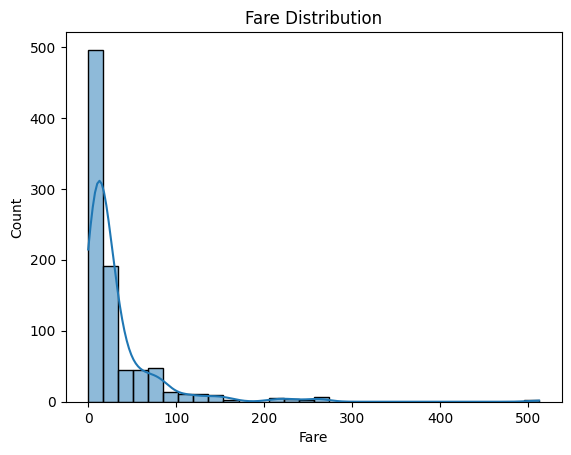

In [102]:
sns.histplot(df['Fare'], kde=True, bins=30)
plt.title('Fare Distribution')
plt.show()

Survival comparison by embarkation port

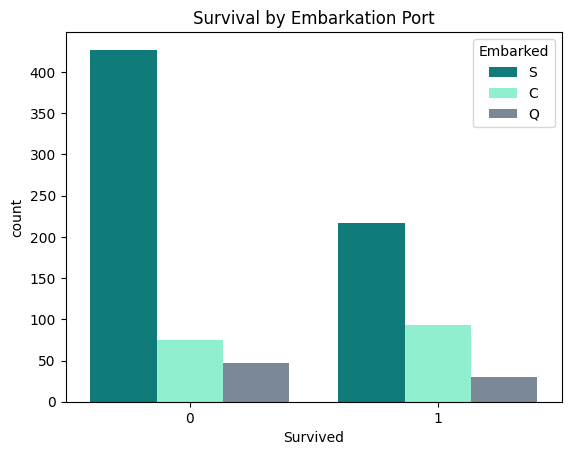

In [103]:
custom_palette = ['darkcyan', 'aquamarine', 'lightslategrey']
sns.countplot(x='Survived', hue='Embarked', data=df, palette=custom_palette)
plt.title('Survival by Embarkation Port')
plt.show()

Correlation matrix between numerical variables

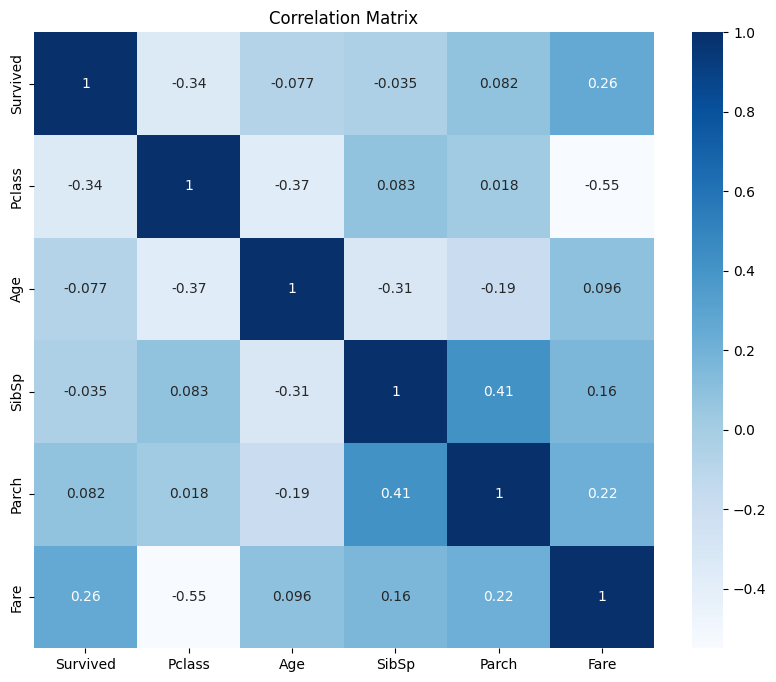

In [104]:
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

#### Cleaning the data

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Look at the distributions of the features to decide with wich method we will fill the null values

<AxesSubplot: >

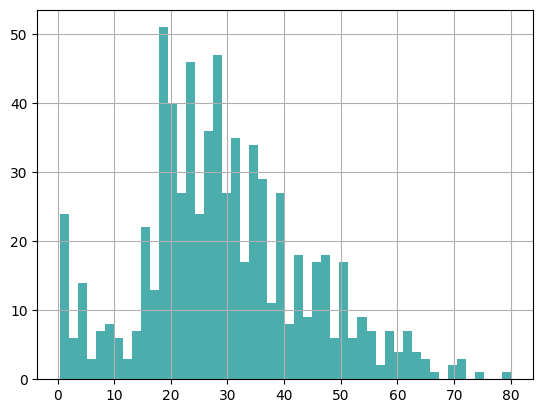

In [106]:
df["Age"].hist(bins=50, color='darkcyan', alpha=0.7)

We will use the median to fill the null values in Age

<AxesSubplot: >

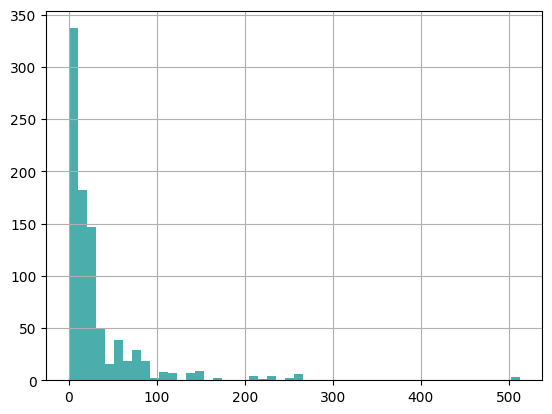

In [107]:
df["Fare"].hist(bins=50, color='darkcyan', alpha=0.7)

We will use the median to fill the null values in Fare

<AxesSubplot: >

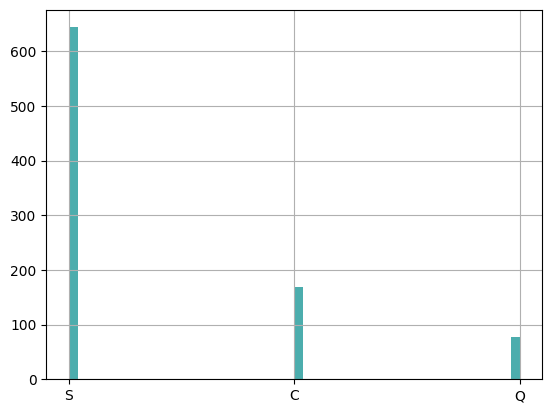

In [108]:
df["Embarked"].hist(bins=50, color='darkcyan', alpha=0.7)

We will use mode to fill the null values in Embarked

FIX THIS: Sabemos que hay un 77.1% de datos faltantes en la columna de 'cabin', intentamos rellenarlo usando un modelo de knn pero no tuvimos un accuracy bueno, despues decidimos probar con random forest, y despues de varios intentos más decidimos eliminar la columna de 'cabin' ya que no obtuvimos los resultados esperados para rellenar esta columna y no aportaba algo bueno a nuestros resultados por lo que lo mejor es mejor no usar la columna.

#### Model Selection

Due the nature of the problem (lots of categorical variables) we will include CatBoost into the comparison of models.

In [109]:
def basic_preprocess_data(data):
    data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    data['Sex'] = data['Sex'].map({'female': 1, 'male': 0})
    data = pd.get_dummies(data, columns=['Embarked'])
    return data

def compare_models(train, test, X_train, y_train, X_test, y_test):

    train.columns = train.columns.str.lower()
    test.columns = test.columns.str.lower()

    features = X_train
    target = y_train

    train_for_cat = train.copy()
    test_for_cat = test.copy()
    train_features_for_cat = train_for_cat.drop('survived', axis=1)
    train_target_for_cat = train_for_cat['survived']
    test_features_for_cat = test_for_cat.drop('survived', axis=1)
    test_target_for_cat = test_for_cat['survived']

    features_index = np.where(train_features_for_cat.dtypes != float)[0]

    cat = CatBoostClassifier(loss_function='Logloss',
                         eval_metric='Accuracy',
                         random_seed=42,
                         verbose=False)

    cat.fit(train_features_for_cat, train_target_for_cat, cat_features=features_index)

    x_train_for_cat = train_features_for_cat
    x_test_for_cat = test_features_for_cat
    y_train_for_cat = train_target_for_cat
    y_test_for_cat = test_target_for_cat

    cat_features_index = np.where(train_features_for_cat.dtypes != float)[0]

    dct_with_models = {}

    for label_model, model in {'RF': [RandomForestClassifier(random_state=42), 'no_scaler'],
                            'DT': [DecisionTreeClassifier(random_state=42), 'no_scaler'],
                            'LR': [LogisticRegression(random_state=42), 'need_scaler'],
                            'KNB': [KNeighborsClassifier(), 'need_scaler'],
                            'SVC': [SVC(random_state=42, probability=True), 'need_scaler'],
                            'CAT': [CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy', verbose=False, use_best_model=True, random_seed=42), 'cat']}.items():
        
        
        if model[1] == 'need_scaler':
            scaled_features = StandardScaler().fit_transform(features)
            scores = cross_val_score(model[0], scaled_features, target, cv=9, scoring='accuracy')
            scaler = StandardScaler()
            scaled_train = scaler.fit_transform(X_train)
            scaled_test = scaler.transform(X_test)
            model[0].fit(scaled_train, y_train)
            dct_with_models[f'{label_model}_overall_accuracy_for_model_for_dataset'] = np.mean(scores)
            dct_with_models[f'{label_model}_accuracy_for_x_test_with_default_params'] = accuracy_score(y_test, model[0].predict(scaled_test))    
            dct_with_models[f'{label_model}_roc_auc_for_x_test_with_default_params'] = roc_auc_score(y_test, model[0].predict_proba(scaled_test)[:,1])
            
        elif model[1] == 'no_scaler':
            scores = cross_val_score(model[0], features, target, cv=9, scoring='accuracy')
            model[0].fit(X_train, y_train)
            dct_with_models[f'{label_model}_overall_accuracy_for_model_for_dataset'] = np.mean(scores)
            dct_with_models[f'{label_model}_accuracy_for_x_test_with_default_params'] = accuracy_score(y_test, model[0].predict(X_test))    
            dct_with_models[f'{label_model}_roc_auc_for_x_test_with_default_params'] = roc_auc_score(y_test, model[0].predict_proba(X_test)[:,1])
        
        elif model[1] == 'cat':
            scores = cv(Pool(train_features_for_cat, train_target_for_cat, cat_features=cat_features_index),
                        {"loss_function": "Logloss",
                        "eval_metric": "Accuracy",
                        "verbose": False,
                        "random_seed": 42},
                        fold_count=5)       
            model[0].fit(x_train_for_cat, y_train_for_cat,
                        cat_features=cat_features_index,
                        eval_set=(x_test_for_cat, y_test_for_cat),
                        verbose=True,
                        plot=False)
            dct_with_models[f'{label_model}_overall_accuracy_for_model_for_dataset'] = scores['test-Accuracy-mean'].mean()
            dct_with_models[f'{label_model}_accuracy_for_x_test_with_default_params'] = accuracy_score(y_test_for_cat, model[0].predict(x_test_for_cat))    
            dct_with_models[f'{label_model}_roc_auc_for_x_test_with_default_params'] = roc_auc_score(y_test_for_cat, model[0].predict_proba(x_test_for_cat)[:,1]) 
    model = []
    overall_accuracy_for_dataset = []
    accuracy_for_x_test_with_default_params = []
    roc_auc_for_x_test_with_default_params = []

    for name_model in ['DT', 'RF', 'LR', 'KNB', 'SVC', 'CAT']:
        model.append(name_model)
        overall_accuracy_for_dataset.append(dct_with_models[f'{name_model}_overall_accuracy_for_model_for_dataset'])
        accuracy_for_x_test_with_default_params.append(dct_with_models[f'{name_model}_accuracy_for_x_test_with_default_params'])
        roc_auc_for_x_test_with_default_params.append(dct_with_models[f'{name_model}_roc_auc_for_x_test_with_default_params']) 

    results = {
    'Model' : model,
    'OVERALL ACCURACY FOR TRAIN DATASET' : pd.Series(overall_accuracy_for_dataset),
    'ROC_AUC FOR X_TEST WITH DEFAULT PARAMS' : pd.Series(roc_auc_for_x_test_with_default_params),
    'ACCURACY FOR X_TEST WITH DEFAULT PARAMS' : pd.Series(accuracy_for_x_test_with_default_params)}

    display(pd.DataFrame(results).style.highlight_max(color='green'))

In [110]:
train = pd.read_csv("train.csv", index_col=0)
train = basic_preprocess_data(train)

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)

len(X_train), len(y_train)

(891, 891)

In [111]:
test = pd.read_csv('test_with_survived.csv', index_col=0)
test = basic_preprocess_data(test)

y_test = test['Survived']
X_test = test.drop(["Survived"], axis=1)

In [112]:
compare_models(train, test, X_train, y_train, X_test, y_test)

Training on fold [0/5]

bestTest = 0.8100558659
bestIteration = 13

Training on fold [1/5]

bestTest = 0.8882681564
bestIteration = 60

Training on fold [2/5]

bestTest = 0.8595505618
bestIteration = 1

Training on fold [3/5]

bestTest = 0.7865168539
bestIteration = 130

Training on fold [4/5]

bestTest = 0.8192090395
bestIteration = 188

Learning rate set to 0.030798
0:	learn: 0.8226712	test: 0.7775120	best: 0.7775120 (0)	total: 60.3ms	remaining: 1m
1:	learn: 0.8193042	test: 0.7751196	best: 0.7775120 (0)	total: 155ms	remaining: 1m 17s
2:	learn: 0.8204265	test: 0.7727273	best: 0.7775120 (0)	total: 232ms	remaining: 1m 17s
3:	learn: 0.8193042	test: 0.7751196	best: 0.7775120 (0)	total: 319ms	remaining: 1m 19s
4:	learn: 0.8170595	test: 0.7751196	best: 0.7775120 (0)	total: 379ms	remaining: 1m 15s
5:	learn: 0.8260382	test: 0.7751196	best: 0.7775120 (0)	total: 471ms	remaining: 1m 18s
6:	learn: 0.8226712	test: 0.7727273	best: 0.7775120 (0)	total: 555ms	remaining: 1m 18s
7:	learn: 0.8249158	tes

,Model,OVERALL ACCURACY FOR TRAIN DATASET,ROC_AUC FOR X_TEST WITH DEFAULT PARAMS,ACCURACY FOR X_TEST WITH DEFAULT PARAMS
0,DT,0.790123,0.710723,0.712919
1,RF,0.808081,0.799769,0.758373
2,LR,0.791246,0.811916,0.765550
3,KNB,0.800224,0.796775,0.717703
4,SVC,0.823793,0.810236,0.779904
5,CAT,0.814097,0.828201,0.799043


As we can see, CatBoost and SVM are the best models for this problem. We will use CatBoost as our base model for the moment.

#### Feature engineering

...

#### Data Preprocessing Function

In [206]:
def preprocess_data(data):

    data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    data['Sex'] = data['Sex'].map({'female': 1, 'male': 0})
    data = pd.get_dummies(data, columns=['Embarked'])

    return data

### Prepare the Data

In [207]:
train = pd.read_csv("train.csv", index_col=0)
train = preprocess_data(train)

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)

len(X_train), len(y_train)

(891, 891)

In [208]:
test = pd.read_csv('test_with_survived.csv', index_col=0)
test = preprocess_data(test)

y_test = test['Survived']
X_test = test.drop(["Survived"], axis=1)

len(X_test), len(y_test)

(418, 418)

### Model

We will use catboost, therefore we need to indicate the categorical features.

In [209]:
cat_features = np.where(X_train.dtypes != float)[0]
cat_features

array([0, 1, 3, 4, 6, 7, 8], dtype=int64)

Create the Model

In [210]:
# fit the model
model = CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy', verbose=False, use_best_model=True, random_seed=42, cat_features=cat_features)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# make predictions
y_pred = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
accuracy # 0.7990430622009569

0.7990430622009569

In [211]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       260
           1       0.77      0.66      0.71       158

    accuracy                           0.80       418
   macro avg       0.79      0.77      0.78       418
weighted avg       0.80      0.80      0.80       418



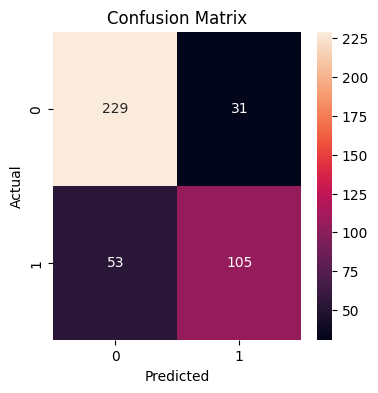

In [212]:
plt.figure(figsize = (4,4))
cm = sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', annot=True)
cm.set(title='Confusion Matrix')
cm.set(xlabel='Predicted', ylabel='Actual')
plt.show()

In [213]:
# get the feature importance
feature_importance = model.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,Sex,42.971406
1,Pclass,18.585748
2,Age,11.570046
3,Fare,9.734781
4,SibSp,7.140632
5,Parch,6.359841
6,Embarked_S,1.829718
7,Embarked_C,1.089721
8,Embarked_Q,0.718109


Hyperparameter Tuning

We are going to find the best parameters for the model using GridSearchCV. Also, we are going to use Cross Validation to avoid overfitting.

In [ ]:
'''
cat_for_search = CatBoostClassifier(loss_function='Logloss',
                                    eval_metric='Accuracy',
                                    verbose=False,
                                    random_state=42)

params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
}

grid = cat_for_search.grid_search(params, Pool(X_train, y_train, cat_features=cat_features), shuffle=True, cv=5, verbose=False,  plot=False)

best_model = CatBoostClassifier(depth=grid['params']['depth'],
                                loss_function='Logloss',
                                eval_metric='Accuracy',
                                use_best_model=True,
                                random_seed=42,
                                verbose=False)

best_model.fit(X_train, y_train, cat_features=cat_features, eval_set = (X_test, y_test))

accuracy_score(y_test, best_model.predict(X_test))
'''

"\ncat_for_search = CatBoostClassifier(loss_function='Logloss',\n                                    eval_metric='Accuracy',\n                                    verbose=False,\n                                    random_state=42)\n\nparams = {\n    'depth': [4, 6, 8, 10],\n    'learning_rate': [0.01, 0.05, 0.1, 0.2],\n    'iterations': [100, 200, 300, 500],\n    'l2_leaf_reg': [1, 3, 5, 7],\n}\n\ngrid = cat_for_search.grid_search(params, Pool(X_train, y_train, cat_features=cat_features), shuffle=True, cv=5, verbose=False,  plot=False)\n\nbest_model = CatBoostClassifier(depth=grid['params']['depth'],\n                                loss_function='Logloss',\n                                eval_metric='Accuracy',\n                                use_best_model=True,\n                                random_seed=42,\n                                verbose=False)\n\nbest_model.fit(X_train, y_train, cat_features=cat_features, eval_set = (X_test, y_test))\n\naccuracy_score(y_test, best_mod